<a href="https://colab.research.google.com/github/chohyungrae/-study-ing-/blob/master/Face_Modificator_with_StyleGAN2_(Eng)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+3">Face Modificator with <font color="green" size="+3">Style<font color="red" size="+3">GAN<font color="green" size="+3">2</font></b>

Based on encoder [stylegan2encoder](https://github.com/rolux/stylegan2encoder) and a set of latent vectors [generators-with-stylegan2](https://github.com/a312863063/generators-with-stylegan2/blob/master/README_EN.md)

*↓ Open me ↓*

##**Put it all together:**
GitHub: [@tg-bomze](https://github.com/tg-bomze)

Telegram: [@bomze](https://t.me/bomze) 

Twitter: [@tg_bomze](https://twitter.com/tg_bomze)

# <b><font color="red" size="+3" >Start</font></b>

In [ ]:
#@title #**Install the required components** { display-mode: "form" }
%%time
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
%matplotlib inline

!rm -rf sample_data
!gdown https://drive.google.com/uc?id=1zWKOc62a_BQy0wVpX9gcPeKq9HajAI4v
!unzip -u stylegan2-encoder-new-full.zip
!rm stylegan2-encoder-new-full.zip

!mkdir networks/other
vgg16 = 'vgg16_zhang_perceptual.pkl'
model = 'stylegan2-ffhq-config-f.pkl'
networks_urls = {
    'european':['https://drive.google.com/uc?id=1--kh2Em5U1qh-H7Lin9FzppkZCQ18c4W','generator_model-stylegan2-config-f.pkl'],
    'asian':['https://drive.google.com/uc?id=1-3XU6KzIVywFoKXx2zG1hW8mH4OYpyO9','generator_yellow-stylegan2-config-f.pkl'],
    'asian beauty':['https://drive.google.com/uc?id=1-04v78_pI59M0IvhcKxsm3YhK2-plnbj','generator_star-stylegan2-config-f.pkl'],
    'baby':['https://drive.google.com/uc?id=1--684mANXSgC3aDhLc7lPM7OBHWuVRXa','generator_baby-stylegan2-config-f.pkl']}

import dnnlib
import pretrained_networks
import dnnlib.tflib as tflib

clear_output()
print(tf.__version__)

1.15.2
CPU times: user 2.12 s, sys: 503 ms, total: 2.62 s
Wall time: 1min 57s


In [ ]:
#@title #**Declare the necessary functions** { display-mode: "form" }
def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = PIL.Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, PIL.Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result


```

```
# <b><font color="red" size="+3" >Generate a hidden vector from a photo</font></b>

Photo uploaded:



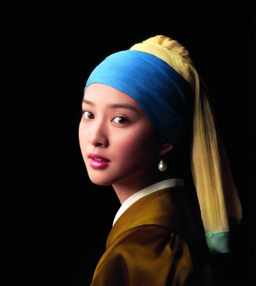

In [ ]:
#@title #**Upload a photo with a face** { display-mode: "form" }
from google.colab import files

!rm -rf raw_images/
!mkdir raw_images/
#@markdown *Enter a link to the image or leave the **url** field blank (in this case it will be offered to upload a photo from the computer).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = files.upload()
  for fp in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))
else:
  try:
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Something went wrong. Try uploading photos from your computer")

os.rename(fp, fp.replace(" ", ""))
fp = fp.replace(" ", "")
fn = 'photo.'+ fp.split('.')[-1]
!mv $fp raw_images/$fn
clear_output()
print("Photo uploaded:\n")

img1 = PIL.Image.open('raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), PIL.Image.LANCZOS)
display(img1)

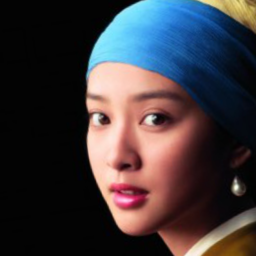

In [ ]:
#@title #**Crop photo** { display-mode: "form" }
!rm -rf aligned_images/
!mkdir aligned_images/
!python align_images.py raw_images/ aligned_images/
align = !ls aligned_images
clear_output()
for i in align:
  display(PIL.Image.open('aligned_images/'+i).resize((256,256)))

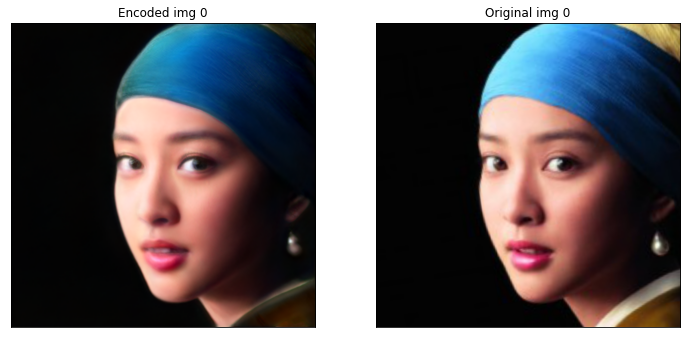


CPU times: user 2.37 s, sys: 435 ms, total: 2.8 s
Wall time: 10min 46s


In [ ]:
#@title #**Train a neural network (~15-20 min.)** { display-mode: "form" }
%%time
!rm -rf latent_representations/ generated_images/
#@markdown **Choose an image encoding method:**

#@markdown *Slow method works 2 times longer, but has much higher quality.*
metod = 'Slow (high quality)' #@param ["Fast (low quality)", "Slow (high quality)"]
#@markdown **Select a network that matches the type of face in the input image.:**

#@markdown *Default network is universal, so if in doubt, choose default.*
network = 'asian beauty' #@param ["default", "european", "asian", "asian beauty", "baby"]
if network == 'default':
  network_path = 'networks/' + model
else:
  other_networks = !ls networks/other
  if networks_urls[network][1] in other_networks:
    network_path = 'networks/other/' + networks_urls[network][1]
  else:
    network_url = networks_urls[network][0]
    try:
      !gdown $network_url
      network_name = networks_urls[network][1]
      !mv $network_name networks/other/$network_name
      network_path = 'networks/other/' + network_name
    except BaseException:
      network_pkl = 'networks/other/' + networks_urls[network][1]
#@markdown **Set the number of iterations of network learning:**

#@markdown *Recommended: 700*
iterat = 750 #@param {type:"slider", min:100, max:1500, step:50}
#@markdown **Set learning rate:**

#@markdown *Recommended: 0.1*
learning_rate = 0.1 #@param {type:"slider", min:0.01, max:1, step:0.01}

#@markdown **Delete logs after executing this block:**
delete_logs = True #@param {type:"boolean"}

if metod == 'Slow (high quality)':
  !python project_images.py \
    aligned_images/ \
    generated_images/ \
    --vgg16-pkl 'networks/vgg16_zhang_perceptual.pkl' \
    --num-steps $iterat \
    --initial-learning-rate $learning_rate \
    --network-pkl $network_path \
    --video=False
  !mkdir latent_representations/
  for i in align:
    vector_name = i.split('.')[0]+'.npy'
    !mv generated_images/$vector_name latent_representations/$vector_name
else:
  !python encode_images.py \
    aligned_images/ \
    generated_images/ \
    latent_representations/ \
    --network_pkl $network_path \
    --image_size 1024 \
    --iterations $iterat \
    --lr $learning_rate \
    --batch_size 2

fn = !ls latent_representations
pass
if delete_logs == True:
  clear_output()
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [ ]:
#@title #**(Optional) Download the generated vector and image** { display-mode: "form" }

download_vector = True #@param {type:"boolean"}
if download_vector == True:
  files.download("latent_representations/photo_01.npy")

download_picture = True #@param {type:"boolean"}
if download_picture == True:
  files.download("generated_images/photo_01.png")

#@markdown *The bottom checkmark will simply show the thumbnail of the generated image under this block.*
show_image = False #@param {type:"boolean"}
if show_image == True:
  img2 = PIL.Image.open('generated_images/photo_01.png')
  wpercent = (256/float(img2.size[0]))
  hsize = int((float(img2.size[1])*float(wpercent)))
  img2 = img2.resize((256,hsize), PIL.Image.LANCZOS)
  display(img2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


```

```
# <b><font color="red" size="+3" >Generator</font></b>

In [ ]:
#@title #**(Optional) Upload your vector** { display-mode: "form" }

#@markdown *This block is optional. If you have a saved vector, then you can upload it*
from google.colab import files
!rm -rf latent_representations
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir latent_representations
!mv $fn latent_representations/$fn
fn = [fn]
clear_output()

In [ ]:
#@title #**Configure the generator** { display-mode: "form" }

#@markdown *Below select the network in which the feature vector was generated*
network = 'asian beauty' #@param ["default", "european", "asian", "asian beauty", "baby"]

if network == 'default':
  network_pkl = 'networks/' + model
else:
  other_networks = !ls networks/other
  if networks_urls[network][1] in other_networks:
    network_pkl = 'networks/other/' + networks_urls[network][1]
  else:
    network_url = networks_urls[network][0]
    try:
      !gdown $network_url
      network_name = networks_urls[network][1]
      !mv $network_name networks/other/$network_name
      network_pkl = 'networks/other/' + network_name
    except BaseException:
      network_pkl = 'networks/other/' + networks_urls[network][1]

tflib.init_tf()
with open(network_pkl, "rb") as f:
  generator_network, discriminator_network, Gs_network = pickle.load(f)

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5
clear_output()

```

```
# <b><font color="red" size="+3" >Generate photos and animations</font></b>

In [ ]:
#@title #**Modify the face in photo** { run: "auto", display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'smile' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Parameter intensity:**
intensity = 5 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
boost_intensity = True #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 3
coeffs = [intensity]
#@markdown **Image resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

ValueError: ignored

In [ ]:
#@title #**Animating a face modification** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'eyes_open' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Starting intensity:**
start_intensity = 0 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Finishing intensity:**
finish_intensity = 10 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Number of frames:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:
  #@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
  boost_intensity = True #@param {type:"boolean"}
  if boost_intensity == True:
    start_intensity *= 3
    finish_intensity *= 3
  
  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)
  #@markdown **Animation Resolution:**
  resolution = "256" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

  #@markdown **Add video Invert:**

  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
    face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Starting intensity should be less than the finish!')

```

```
# <b><font color="red" size="+3" >Additional functions</font></b>

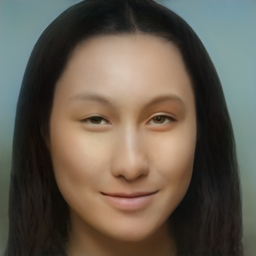

In [ ]:
#@title #**Modify the face according to 3 parameters** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/3param

#@markdown **Choose the first option:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 7 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity1 = True #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3

#@markdown **Choose the second option:**
parameter2 = 'race_yellow' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 5 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity2 = True #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3

#@markdown **Choose the third option:**
parameter3 = 'emotion_happy' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 4 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity3 = True #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3

#@markdown **Image resolution:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = PIL.Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, PIL.Image.ANTIALIAS)
    result.save('results/3param/result_3param.png')
    return result

direction_intensity = (direction_file1*intensity1) + (direction_file2*intensity2) + (direction_file3*intensity3)
move_latent_and_save_3_param(v, direction_intensity, Gs_network, Gs_syn_kwargs)

In [ ]:
#@title #**Animating face modification (3 parameters)** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/3param

#@markdown **Number of frames:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **Choose the first option:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 10 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity1 == 0: intensity1 += 0.001
boost_intensity1 = True #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3
coeffs1 = []
for i in range(0, frames):
  coeffs1.append(round((i*intensity1)/frames,3))

#@markdown **Choose the second option:**
parameter2 = 'race_yellow' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 8 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity2 == 0: intensity2 += 0.001
boost_intensity2 = True #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

#@markdown **Choose the third option:**
parameter3 = 'emotion_happy' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 7 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity3 == 0: intensity3 += 0.001
boost_intensity3 = True #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

#@markdown **Animation Resolution:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, frame_num, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = PIL.Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, PIL.Image.ANTIALIAS)
    result.save('results/3param/result_(' + str(frame_num+1000) + ')_3param.png')
    return result

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  move_latent_and_save_3_param(v, direction_intensity, i, Gs_network, Gs_syn_kwargs)
  #clear_output()
  #print('Сгенерированно ' + str(i) + ' фото из ' + str(frames))

#@markdown **Add video Invert:**

add_invert = True #@param {type:"boolean"}
face_img = []
img = os.listdir("results/3param")
img.sort()
clear_output()
print('Animation is created. Please wait.')
for i in img:
  face_img.append(imageio.imread("results/3param/"+i))
if add_invert == True:
  for j in reversed(face_img):
    face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("results/3param/3param.mp4", face_img)
display(mpy.ipython_display("results/3param/3param.mp4", height=400, autoplay=1, loop=1))

Анимация формируется. Пожалуйста подождите.
